In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import albumentations as A

from skimage import exposure
import os
import pydicom
import torch
from pathlib import Path
from torchvision import transforms
import sys
import matplotlib.pyplot as plt

from skimage import exposure

import time
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Dataset

In [123]:
#load image npy
image_1 = np.load(f"/kaggle/input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy",mmap_mode='r')[:1000]
masks_1 = np.load(f"/kaggle/input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy",mmap_mode='r')[:1000]
labels = np.load(f"/kaggle/input/cancer-inst-segmentation-and-classification/Part 1/Images/types.npy",mmap_mode='r')[:1000]

In [124]:
# delete pairs with no cells
 
index = [584, 586, 604, 748, 750, 780, 811, 812, 813, 828, 830, 832, 833,
         996, 998]  
image_1 = np.delete(image_1, index, 0)
masks_1 = np.delete(masks_1, index, 0)
labels = np.delete(labels, index, 0)

In [4]:
#print shape of image npy
print(image_1.shape)
print(masks_1.shape)

(985, 256, 256, 3)
(985, 256, 256, 6)


In [5]:
#Change the dtype to int to show the image
image_1_32=image_1.astype('int32')
masks_1_32=masks_1.astype('int32')

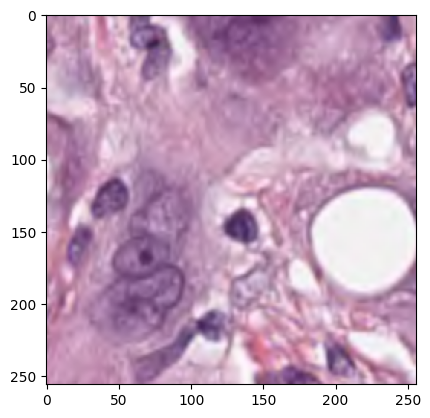

In [6]:
# example image
plt.imshow(image_1_32[1])


In [7]:
labels[550]

'Breast'

## Data Pre-Processing

In [8]:
def enhance_image(image):
    """
    Enhances a single image using edge enhancement with Gaussian method and contrast enhancement.

    Args:
    image (numpy array): The input image in numpy array format.

    Returns:
    numpy array: The enhanced image.
    """
    # Edge enhancement using Gaussian method
    # Creating a Gaussian kernel
    gaussian_kernel = cv2.getGaussianKernel(ksize=5, sigma=0)
    # Applying the kernel to the image
    enhanced_image = cv2.filter2D(src=image, ddepth=-1, kernel=gaussian_kernel)

    # Enhance contrast
    # Converting to float as exposure.equalize_adapthist requires floating point images
    enhanced_image = enhanced_image.astype('float32') / 255
    # Adaptive histogram equalization
    enhanced_image = exposure.equalize_adapthist(enhanced_image)

    return enhanced_image


def process_guassian_K(img_array):
    # Read the DICOM file
    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)
    # Convert to color image
    color_img = img_array#cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)

    # Reshape the image to a 2D array of pixels
    reshaped_img = color_img.reshape((-1, 3))
    # Convert to float32 for k-means
    reshaped_img = np.float32(reshaped_img)

    # Define criteria, number of clusters(K) and apply k-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.5)
    K = 5  # Number of clusters
    _, labels, centers = cv2.kmeans(reshaped_img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to uint8
    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(color_img.shape)

    # Apply Gaussian Blur with a 9x9 kernel to segmented image
    blurred_img = cv2.GaussianBlur(segmented_img, (5, 5), 0)
    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_img, 100, 200)
    # Overlay edges in red on the segmented image
    segmented_img[edges > 0] = [255, 0, 0]

    return segmented_img

def process_guassain(img_array, kernel = 9):

    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)
    # Convert to color image
    color_img = img_array
    # Apply Gaussian Blur with a 9x9 kernel
    blurred_img = cv2.GaussianBlur(color_img, (kernel, kernel), 0)
    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_img, 100, 200)
    # Overlay edges in red on the original image
    color_img[edges > 0] = [255, 0, 0]
    return color_img

def process_gaussian_get_item(img_tensor):
    # Convert the tensor to a numpy array
    if torch.is_tensor(img_tensor):
        img_array = img_tensor.detach().cpu().numpy()
    else:
        img_array = img_tensor  # assuming it's already a numpy array

    # Transpose and rescale to 0-255
    img_array = np.transpose(img_array, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    img_array = (np.maximum(img_array, 0) / img_array.max()) * 255.0
    img_array = np.uint8(img_array)

    # Apply Gaussian Blur
    blurred_img = cv2.GaussianBlur(img_array, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_img, 100, 200)

    # Create an overlay with edges in red
    overlay = np.zeros_like(img_array)
    overlay[edges > 0] = [0, 255, 0]
    color_img_with_edges = cv2.addWeighted(img_array, 1, overlay, 1, 0)

    return color_img_with_edges



def process_gaussian_K_vectorized(img_set):
    # Normalizing and converting to uint8 in a vectorized manner
    img_set = np.maximum(img_set, 0)
    img_set = (img_set / img_set.max(axis=(1, 2, 3), keepdims=True)) * 255.0
    img_set = img_set.astype(np.uint8)

    processed_images = []
    for img_array in img_set:
        # Reshape the image to a 2D array of pixels
        reshaped_img = img_array.reshape((-1, 3))
        # Convert to float32 for k-means
        reshaped_img = np.float32(reshaped_img)

        # Define criteria, number of clusters(K) and apply k-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        K = 5  # Number of clusters
        _, labels, centers = cv2.kmeans(reshaped_img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert back to uint8 and reshape to original shape
        centers = np.uint8(centers)
        segmented_img = centers[labels.flatten()]
        segmented_img = segmented_img.reshape(img_array.shape)

        # Apply Gaussian Blur and Canny Edge Detection
        blurred_img = cv2.GaussianBlur(segmented_img, (5, 5), 0)
        edges = cv2.Canny(blurred_img, 100, 200)

        # Overlay edges in red on the segmented image
        segmented_img[edges > 0] = [255, 0, 0]

        processed_images.append(segmented_img)

    return np.array(processed_images)



In [9]:
def convert_3d_mask_to_2d(mask_3d):
    """
    Convert a 3D mask to a 2D mask.
    
    For each pixel, if it has a non-zero value in the first five channels of the 3D mask,
    the corresponding value in the 2D mask will be set to the channel number (1-5).
    If no non-zero value is found in the first five channels, it's set to 255.
    
    Parameters:
    mask_3d (numpy.ndarray): A 3D numpy array of shape (256, 256, 6)
    
    Returns:
    numpy.ndarray: A 2D numpy array of shape (256, 256)
    """
    # Check if the mask_3d has the correct shape
    if mask_3d.shape != (256, 256, 6):
        raise ValueError("Input mask must have shape (256, 256, 6)")

    # Initialize the 2D mask with all 255s
    mask_2d = np.full((256, 256), 6, dtype=int)

    # Iterate over each channel and update the 2D mask
    for channel in range(5):  # Only considering the first five channels
        mask_2d[(mask_3d[:, :, channel] != 0) & (mask_2d == 6)] = channel + 1

    return mask_2d

In [10]:
import numpy as np

def convert_3d_mask_to_2d_vectorized(mask_set):
    # Check if the mask_set has the correct shape
    if mask_set.shape[1:] != (256, 256, 6):
        raise ValueError("Each mask in the mask set must have shape (256, 256, 6)")

    # Initialize the 2D mask array with all 255s
    mask_2d_set = np.full(mask_set.shape[:3], 6, dtype=int)

    # Iterate over each channel and update the 2D mask array
    for channel in range(5):  # Only considering the first five channels
        mask_2d_set[(mask_set[:, :, :, channel] != 0) & (mask_2d_set == 6)] = channel + 1

    return mask_2d_set

In [11]:
def draw_images_side_by_side(original_image, processed_image, mask, alpha=0.3):
    """
    Draw the original image, processed image, and processed image with a mask overlay side by side.
    
    Each class in the mask (1-5) is displayed in a different color on the processed image.
    Class 255 is transparent (no extra color).
    
    Parameters:
    original_image (numpy.ndarray): The original image.
    processed_image (numpy.ndarray): The processed image.
    mask (numpy.ndarray): The mask to overlay on the processed image.
    alpha (float): Transparency factor for the mask.
    """
    if original_image.shape[:2] != mask.shape or processed_image.shape[:2] != mask.shape:
        raise ValueError("Original image, processed image, and mask must have the same dimensions")

    # Define colors for each class
    colors = np.array([
        [0, 0, 0, 0],        # Class 255 - Transparent
        [255, 0, 0, int(255 * alpha)],  # Class 1 - Red
        [0, 255, 0, int(255 * alpha)],  # Class 2 - Green
        [0, 0, 255, int(255 * alpha)],  # Class 3 - Blue
        [255, 255, 0, int(255 * alpha)],# Class 4 - Yellow
        [255, 0, 255, int(255 * alpha)] # Class 5 - Magenta
    ], dtype=np.uint8)

    # Create a color mask
    color_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)
    for i in range(1, 6):
        color_mask[mask == i] = colors[i]
    color_mask[mask == 255] = colors[0]  # For class 255, set transparent

    # Overlay the color mask on the processed image
    combined_image = processed_image.copy()
    for i in range(3):  # RGB channels
        combined_image[:, :, i] = np.where(color_mask[:, :, 3] != 0,
                                           (combined_image[:, :, i] * (1 - alpha) + color_mask[:, :, i] * alpha).astype(np.uint8),
                                           combined_image[:, :, i])

    # Display the original, processed, and masked images side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(processed_image)
    axs[1].set_title("Processed Image")
    axs[1].axis('off')

    axs[2].imshow(combined_image)
    axs[2].set_title("Processed Image with Mask")
    axs[2].axis('off')

    plt.show()
def maks_process_and_show(idx):
    mask = convert_3d_mask_to_2d(masks_1[idx])
    image = image_1_32[idx]
    processed = process_guassain(image_1[idx])
    draw_images_side_by_side(image, processed, mask, alpha=0.4)


### Examine Mask

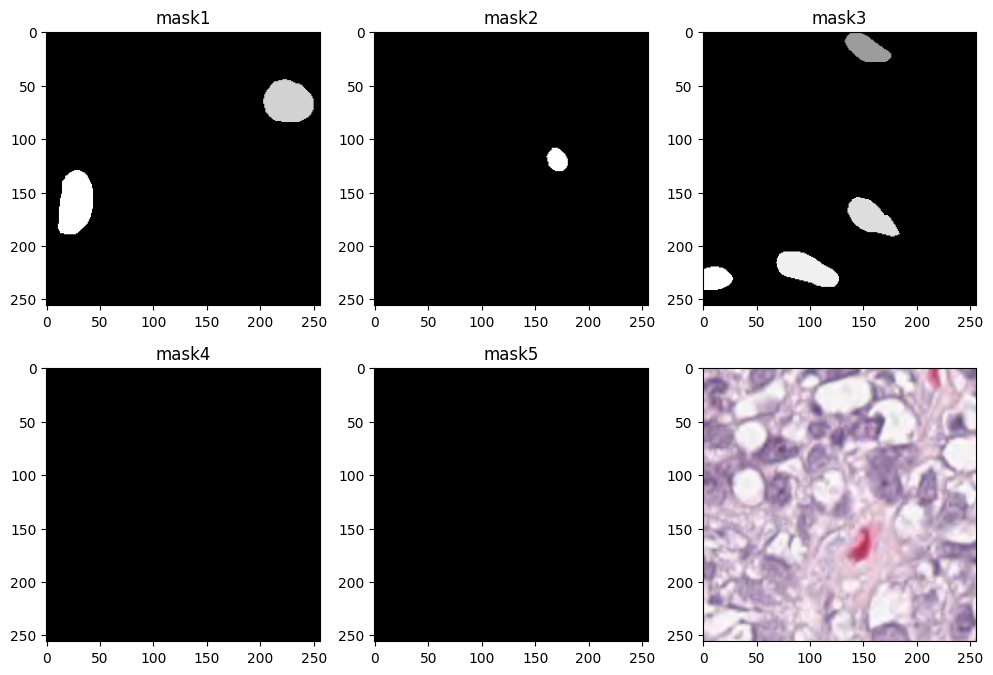

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
for i in range(5):#six data last one is flag, so we only need 0,1,2,3,4
    axes[i].imshow(masks_1[5][:,:,i],cmap='gray')
    axes[i].set_title('mask'+str(i+1))
axes[5]=plt.imshow(image_1_32[550])

### Examine Masks and Data Processing

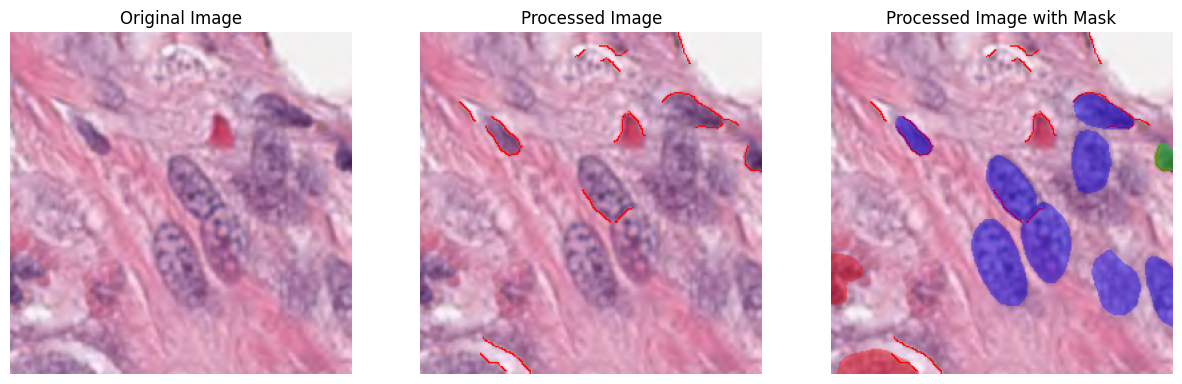

In [13]:
maks_process_and_show(8)

In [14]:
mask_2d = convert_3d_mask_to_2d_vectorized(masks_1) - 1
images =  np.uint8(image_1)#process_gaussian_K_vectorized(image_1)#

In [15]:
print(mask_2d.shape)
print(images.shape)

(985, 256, 256)
(985, 256, 256, 3)


## Data Loader

In [44]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np

class DroneDataset(Dataset):
    
    def __init__(self, images, masks, mean, std, transform=None, patch=False):
        """
        Initialize the dataset.
        :param images: Numpy array of images.
        :param masks: Numpy array of masks.
        :param mean: Mean for normalization.
        :param std: Standard deviation for normalization.
        :param transform: Optional transformation to apply.
        :param patch: Whether to generate patches from images.
        """
        self.images = images
        self.masks = masks
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform is not None:
            aug = self.transform(image=img, mask=np.array(mask))
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)

        # Apply standard transformations
        t = T.Compose([T.ToTensor()])
        
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        """
        Generate patches from the image and mask.
        :param img: Image tensor.
        :param mask: Mask tensor.
        :return: Patches of the image and mask.
        """
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches


In [48]:
class DroneDataset(Dataset):
    def __init__(self, masks, labels, mean=None, std=None, transform=None):
        self.masks = masks
        self.labels = labels
        self.mean = mean
        self.std = std
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        mask = self.masks[idx]
        
        if self.transform is not None:
            # Resize the image and mask together
            aug = self.transform(image=img, mask=mask)
            mask = aug['mask']
        
        
        return mask, self.labels[idx]


In [16]:
!pip install -U albumentations

Batch 1
torch.Size([3, 256, 256])


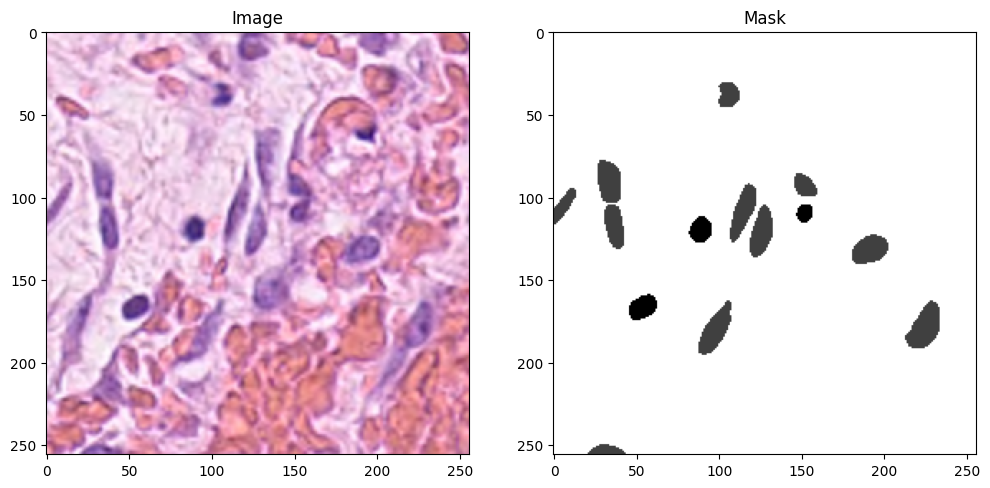

In [19]:
t_train = A.Compose([
   A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.RandomCrop(680, 1032),  # Random crop
    A.PadIfNeeded(min_height=704, min_width=1056, border_mode=cv2.BORDER_CONSTANT),  # Pad the image back to (704, 1056)
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=30),  # Random rotation
    A.ElasticTransform(alpha=1, sigma=50),  # Elastic transform
    #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10),  # HSV adjustments
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    A.RandomGamma(gamma_limit=(80, 120)),  # Random gamma
    A.CLAHE(clip_limit=4.0, p=0.7),  # CLAHE
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0,0.5),(0,0.5)),
    A.GaussNoise()
], is_check_shapes=False)

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
], is_check_shapes=False)


dataset = DroneDataset(images, mask_2d, mean=[0.4, 0.27, 0.57], std=[0.4131182, 0.3946274, 0.4131182])

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Function to display images and masks
def show(img, mask):
    np_img = img.numpy().transpose((1, 2, 0))
    #np_img = process_guassain(np_img,9)
    np_mask = mask.numpy()
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(np_img)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(np_mask, cmap='gray')
    plt.title('Mask')
    plt.show()
    
# Iterate over the DataLoader
for i, (img, mask) in enumerate(dataloader):
    print(f"Batch {i+1}")
    # Display the first image and mask in the batch
    print(img[0].shape)
    show(img[0], mask[0])

    # For demonstration, only show the first batch
    if i == 0:
        break
    break

In [20]:
import albumentations as A
from torch.utils.data import DataLoader

# Assuming you have these numpy arrays ready
# X_train, y_train - Training images and masks
# X_val, y_val - Validation images and masks

# Transformations (using your provided transformations)
# t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
#                      A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
#                      A.GaussNoise()])

# t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
#                    A.GridDistortion(p=0.2)])

# Mean and Standard Deviation
mean = [0.17066666, 0.17066666, 0.17066666]
std = [0.4131182, 0.3946274, 0.4131182]

# Instantiate the datasets
train_set = DroneDataset(images[:800], mask_2d[:800], mean=mean, std=std, transform = t_train)
val_set = DroneDataset(images[800:900], mask_2d[800:900], mean=mean, std=std, transform = t_val)
test_set = DroneDataset(images[900:1000], mask_2d[900:1000], mean=mean, std=std, transform = t_val)

# Batch size
batch_size = 3

# DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

# Now you can use train_loader and val_loader in your training loop


In [21]:
import numpy as np

def calculate_mean_std(image_set):
    """
    Calculate the mean and standard deviation of an image dataset.
    Assumes images are in the format (N, H, W, C) where N is the number of images,
    H is height, W is width, and C is the number of channels.

    :param image_set: A numpy array of images.
    :return: Tuple of mean and standard deviation for each channel.
    """
    # Convert images to float and scale to [0, 1] if they are in [0, 255]
    if image_set.dtype == np.uint8:
        image_set = image_set.astype(np.float32) / 255.0

    # Calculate mean and std
    mean = np.mean(image_set, axis=(0, 1, 2))
    std = np.std(image_set, axis=(0, 1, 2))

    return mean, std

# Example usage
# Assuming img_set is your dataset with shape (N, H, W, C)
# For instance: img_set = np.random.randint(0, 256, (500, 256, 256, 3), dtype=np.uint8)
mean, std = calculate_mean_std(images)
print("Mean: ", mean)
print("Standard Deviation: ", std)


Mean:  [0.25989848 0.25989848 0.25989848]
Standard Deviation:  [0.4001793  0.36173508 0.38053313]


## Model Loading

In [25]:
model = smp.DeepLabV3('timm-regnetx_064', encoder_weights='imagenet', classes=6)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_064-29278baa.pth" to /root/.cache/torch/hub/checkpoints/regnetx_064-29278baa.pth
100%|██████████| 100M/100M [00:01<00:00, 79.1MB/s] 


In [26]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [27]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [29]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    #print(model)
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)

                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Res2Nxt_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 15:
                    print('Loss not decrease for 15 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
            #sched.step(test_loss/len(val_loader))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [30]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [31]:
max_lr = 1e-3
epoch =30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
#optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.859 
Epoch:1/30.. Train Loss: 1.067.. Val Loss: 0.859.. Train mIoU:0.166.. Val mIoU: 0.221.. Train Acc:0.691.. Val Acc:0.776.. Time: 21.83m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.859 >> 0.738 
Epoch:2/30.. Train Loss: 0.713.. Val Loss: 0.738.. Train mIoU:0.186.. Val mIoU: 0.224.. Train Acc:0.781.. Val Acc:0.774.. Time: 22.06m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.738 >> 0.691 
Epoch:3/30.. Train Loss: 0.610.. Val Loss: 0.691.. Train mIoU:0.221.. Val mIoU: 0.232.. Train Acc:0.792.. Val Acc:0.778.. Time: 21.91m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.691 >> 0.655 
saving model...
Epoch:4/30.. Train Loss: 0.528.. Val Loss: 0.655.. Train mIoU:0.268.. Val mIoU: 0.252.. Train Acc:0.816.. Val Acc:0.781.. Time: 21.26m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.655 >> 0.612 
Epoch:5/30.. Train Loss: 0.481.. Val Loss: 0.612.. Train mIoU:0.298.. Val mIoU: 0.278.. Train Acc:0.834.. Val Acc:0.791.. Time: 22.03m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.612 >> 0.576 
Epoch:6/30.. Train Loss: 0.441.. Val Loss: 0.576.. Train mIoU:0.334.. Val mIoU: 0.312.. Train Acc:0.846.. Val Acc:0.799.. Time: 21.98m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.576 >> 0.553 
Epoch:7/30.. Train Loss: 0.420.. Val Loss: 0.553.. Train mIoU:0.361.. Val mIoU: 0.337.. Train Acc:0.853.. Val Acc:0.806.. Time: 21.96m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.553 >> 0.523 
Epoch:8/30.. Train Loss: 0.401.. Val Loss: 0.523.. Train mIoU:0.391.. Val mIoU: 0.353.. Train Acc:0.859.. Val Acc:0.814.. Time: 21.54m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.523 >> 0.494 
saving model...
Epoch:9/30.. Train Loss: 0.384.. Val Loss: 0.494.. Train mIoU:0.414.. Val mIoU: 0.376.. Train Acc:0.864.. Val Acc:0.819.. Time: 21.95m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.494 >> 0.480 
Epoch:10/30.. Train Loss: 0.377.. Val Loss: 0.480.. Train mIoU:0.427.. Val mIoU: 0.383.. Train Acc:0.866.. Val Acc:0.821.. Time: 21.97m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:11/30.. Train Loss: 0.360.. Val Loss: 0.509.. Train mIoU:0.445.. Val mIoU: 0.372.. Train Acc:0.870.. Val Acc:0.815.. Time: 22.07m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.509 >> 0.490 
Epoch:12/30.. Train Loss: 0.356.. Val Loss: 0.490.. Train mIoU:0.450.. Val mIoU: 0.390.. Train Acc:0.873.. Val Acc:0.818.. Time: 21.74m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.490 >> 0.484 
Epoch:13/30.. Train Loss: 0.349.. Val Loss: 0.484.. Train mIoU:0.453.. Val mIoU: 0.376.. Train Acc:0.874.. Val Acc:0.819.. Time: 21.68m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:14/30.. Train Loss: 0.355.. Val Loss: 0.484.. Train mIoU:0.461.. Val mIoU: 0.379.. Train Acc:0.873.. Val Acc:0.819.. Time: 21.64m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/30.. Train Loss: 0.344.. Val Loss: 0.489.. Train mIoU:0.463.. Val mIoU: 0.379.. Train Acc:0.877.. Val Acc:0.820.. Time: 21.41m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.489 >> 0.455 
Epoch:16/30.. Train Loss: 0.335.. Val Loss: 0.455.. Train mIoU:0.467.. Val mIoU: 0.401.. Train Acc:0.879.. Val Acc:0.825.. Time: 22.39m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.455 >> 0.434 
saving model...
Epoch:17/30.. Train Loss: 0.326.. Val Loss: 0.434.. Train mIoU:0.475.. Val mIoU: 0.412.. Train Acc:0.882.. Val Acc:0.834.. Time: 21.11m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:18/30.. Train Loss: 0.338.. Val Loss: 0.442.. Train mIoU:0.473.. Val mIoU: 0.395.. Train Acc:0.879.. Val Acc:0.830.. Time: 21.56m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.442 >> 0.437 
Epoch:19/30.. Train Loss: 0.326.. Val Loss: 0.437.. Train mIoU:0.483.. Val mIoU: 0.410.. Train Acc:0.883.. Val Acc:0.834.. Time: 21.47m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:20/30.. Train Loss: 0.329.. Val Loss: 0.449.. Train mIoU:0.478.. Val mIoU: 0.400.. Train Acc:0.882.. Val Acc:0.834.. Time: 21.63m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.449 >> 0.437 
Epoch:21/30.. Train Loss: 0.323.. Val Loss: 0.437.. Train mIoU:0.482.. Val mIoU: 0.396.. Train Acc:0.883.. Val Acc:0.835.. Time: 22.45m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:22/30.. Train Loss: 0.324.. Val Loss: 0.444.. Train mIoU:0.480.. Val mIoU: 0.393.. Train Acc:0.883.. Val Acc:0.833.. Time: 21.86m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.444 >> 0.435 
Epoch:23/30.. Train Loss: 0.316.. Val Loss: 0.435.. Train mIoU:0.492.. Val mIoU: 0.397.. Train Acc:0.886.. Val Acc:0.837.. Time: 21.46m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.435 >> 0.433 
Epoch:24/30.. Train Loss: 0.313.. Val Loss: 0.433.. Train mIoU:0.499.. Val mIoU: 0.406.. Train Acc:0.888.. Val Acc:0.838.. Time: 21.60m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:25/30.. Train Loss: 0.314.. Val Loss: 0.448.. Train mIoU:0.494.. Val mIoU: 0.389.. Train Acc:0.887.. Val Acc:0.834.. Time: 21.91m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.448 >> 0.435 
saving model...
Epoch:26/30.. Train Loss: 0.315.. Val Loss: 0.435.. Train mIoU:0.496.. Val mIoU: 0.415.. Train Acc:0.887.. Val Acc:0.840.. Time: 21.78m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:27/30.. Train Loss: 0.309.. Val Loss: 0.438.. Train mIoU:0.503.. Val mIoU: 0.407.. Train Acc:0.889.. Val Acc:0.836.. Time: 22.49m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Decreasing.. 0.438 >> 0.428 
Epoch:28/30.. Train Loss: 0.305.. Val Loss: 0.428.. Train mIoU:0.504.. Val mIoU: 0.401.. Train Acc:0.889.. Val Acc:0.840.. Time: 21.91m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:29/30.. Train Loss: 0.310.. Val Loss: 0.437.. Train mIoU:0.501.. Val mIoU: 0.403.. Train Acc:0.888.. Val Acc:0.837.. Time: 22.15m


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:30/30.. Train Loss: 0.306.. Val Loss: 0.476.. Train mIoU:0.501.. Val mIoU: 0.395.. Train Acc:0.890.. Val Acc:0.830.. Time: 20.78m
Total time: 653.58 m


In [33]:
torch.save(model, 'Unet-vt.pt')

In [34]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

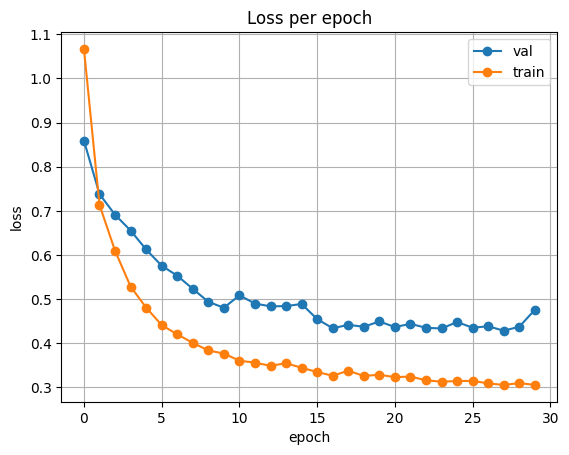

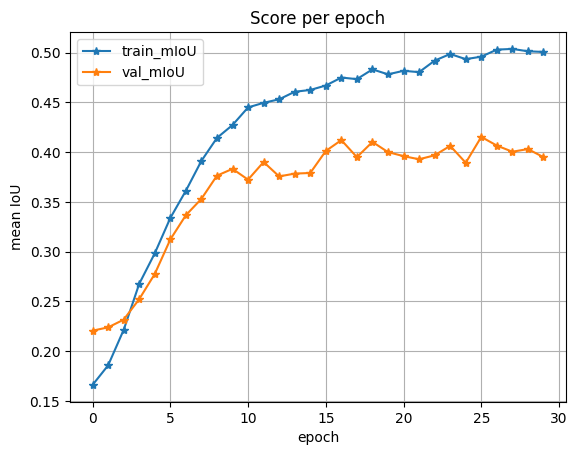

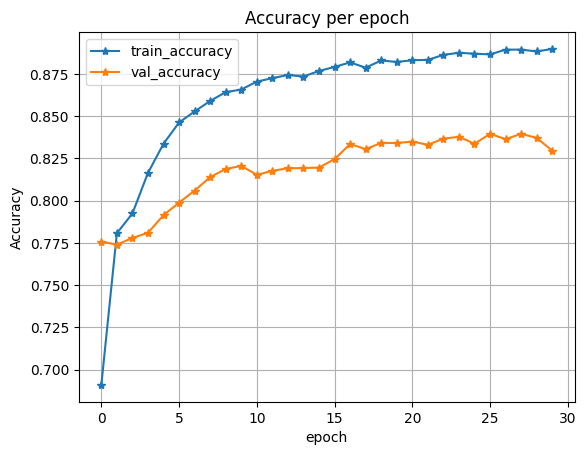

In [35]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Result

In [36]:
def predict_image_mask_miou(model, image, mask, mean=[0.512, 0.512, 0.512], std=[0.3079274, 0.2269147, 0.26827636]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [58]:
def predict_image_mask_pixel(model, image, mask, mean, std):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        # Check if the input image is not already a tensor
        if not isinstance(image, torch.Tensor):
            # Convert image to tensor and normalize
            t = T.Compose([
                T.ToTensor(), 
                T.Normalize(mean, std)
            ])
            image = t(image)
        else:
            # Assuming image is already a tensor, apply normalization directly
            normalize = T.Normalize(mean, std)
            image = normalize(image.unsqueeze(0)).squeeze(0)  # Add and remove batch dimension for normalization
        
        image = image.to(device)
        mask = mask.to(device)
        model.to(device)
        
        # Forward pass to get the output from the model
        with torch.no_grad():
            output = model(image.unsqueeze(0))  # Add a batch dimension
        # Assuming the output is a single channel corresponding to the predicted mask,
        # and the mask is a LongTensor of the same spatial dimensions as the output
        
        # Convert the model output to the predicted mask
        _, predicted = torch.max(output.data, 1)
        pred_mask = predicted.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy for comparison
        
        # Calculate accuracy
        correct = (pred_mask == mask.cpu().numpy()).sum()
        total = mask.numel()
        acc = correct / total
        
        return pred_mask, acc
    except Exception as e:
        print(f"Encountered an error: {e}")
        # Return None for pred_mask and 0 for acc as error indicators
        return None, 0

In [49]:
image, mask = val_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [50]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [47]:
mob_miou = miou_score(model, test_set)
mob_miou[5]

  0%|          | 0/85 [00:00<?, ?it/s]

[0.47309984616822015,
 0.39642876708880315,
 0.27591193359555344,
 0.3710932210679368,
 0.3774914854648545,
 0.3212234886237799,
 0.34235307819258926,
 0.42071721628519526,
 0.7035402339112017,
 0.5178878569373985,
 0.6016680264046556,
 0.47554116079660536,
 0.6136206038469414,
 0.6617583131101241,
 0.7540121981502941,
 0.546399886775532,
 0.5331246503936817,
 0.4088186591833406,
 0.48540937797967243,
 0.3147516228195917,
 0.5557057033993692,
 0.37124896097258886,
 0.5163669739126707,
 0.4015470893332332,
 0.44349786027491683,
 0.41816464903205763,
 0.35865077957040287,
 0.5231654986794969,
 0.3015303995037988,
 0.41976818878033073,
 0.22221868643569517,
 0.30990692341932813,
 0.4654739934320944,
 0.4479617927717009,
 0.48564286770393283,
 0.39923066014209857,
 0.5298754816847336,
 0.4689800579011713,
 0.4394647582276708,
 0.4479323569922711,
 0.20448419079181449,
 0.22063346540432824,
 0.3149230894182971,
 0.24233186820782826,
 0.38578647008601263,
 0.3746670477290782,
 0.242403484660

In [54]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask,mean,std)
        accuracy.append(acc)
    return accuracy

In [59]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/85 [00:00<?, ?it/s]

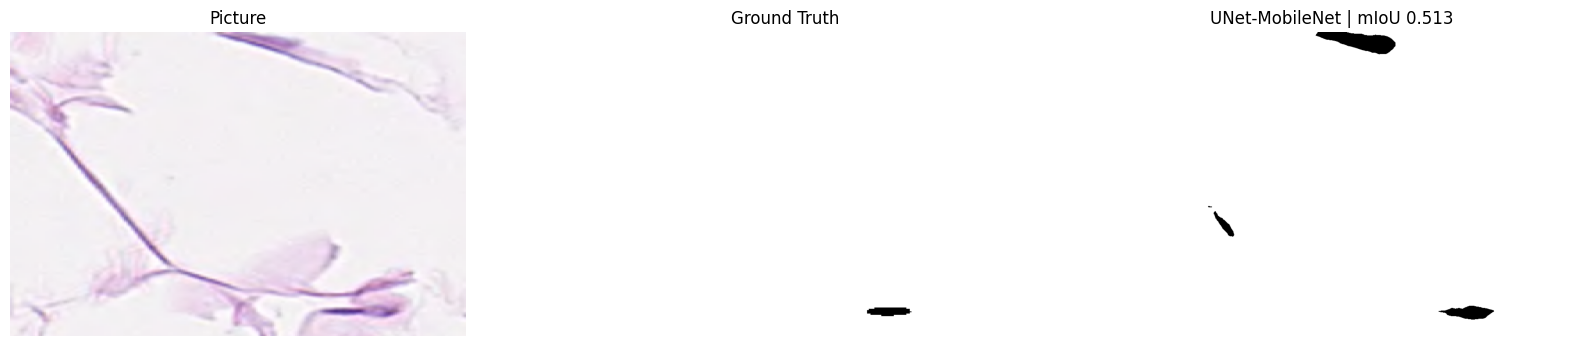

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `image`, `mask`, and `pred_mask` are PyTorch tensors
# and `score` is a scalar value

# Convert tensors to numpy arrays and adjust dimensions if necessary
image_np = image.numpy()
mask_np = mask.numpy()
pred_mask_np = pred_mask.numpy()

# If the image is a tensor with shape (3, H, W), transpose it to (H, W, 3) for RGB images
if image_np.shape[0] == 3:
    image_np = np.transpose(image_np, (1, 2, 0))

# If the mask and predicted mask are not in (H, W, 3), you may need to convert them 
# or ensure they are displayed correctly as grayscale or single-channel images

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image_np)
ax1.set_title('Picture')
ax1.axis('off')

ax2.imshow(mask_np, cmap='gray')
ax2.set_title('Ground Truth')
ax2.axis('off')

ax3.imshow(pred_mask_np, cmap='gray')
ax3.set_title(f'UNet-MobileNet | mIoU {score:.3f}')
ax3.axis('off')

plt.show()

In [63]:
# Iterate over the DataLoader
for i, (img, mask) in enumerate(dataloader):
    print(f"Batch {i+1}")
    # Display the first image and mask in the batch
    model.eval()
    model.to(device); 
    img=img.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        
        img = img.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(img[0])
        #score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    #show(img[0], mask[0])

    # For demonstration, only show the first batch
    if i == 0:
        break
    break

Batch 1


In [ ]:
dataset = DroneDataset(images, mask_2d, mean=[0.512, 0.512, 0.512], std=[0.3079274, 0.2269147, 0.26827636])

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Function to display images and masks
def show(img, mask):
    np_img = img.numpy().transpose((1, 2, 0))
    np_mask = mask.numpy()
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(np_img)
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(np_mask, cmap='gray')
    plt.title('Mask')
    plt.show()

# Iterate over the DataLoader
for i, (img, mask) in enumerate(dataloader):
    print(f"Batch {i+1}")
    # Display the first image and mask in the batch
    show(img[0], mask[0])
    model.eval()
    model.to(device);

    # For demonstration, only show the first batch
    if i == 0:
        break
    break

Batch 1
torch.Size([2, 3, 256, 256])
(256, 256)


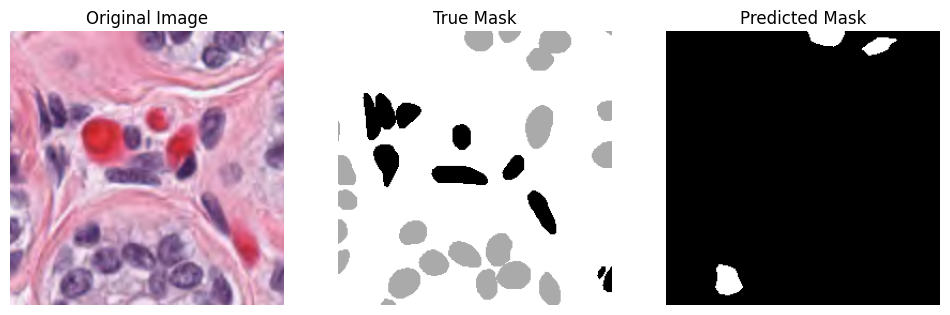

In [67]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def tensor_to_numpy(tensor):
    tensor = tensor.detach().cpu()
    if tensor.ndim == 3:
        return tensor.numpy().transpose(1, 2, 0)  # For 3D tensors (e.g., RGB images)
    elif tensor.ndim == 2:
        return tensor.numpy()  # For 2D tensors (e.g., grayscale images)
    else:
        raise ValueError("Tensor has unsupported number of dimensions: {}".format(tensor.ndim))



# Function to display images
def show_images(original, true_mask, predicted_mask):
    plt.figure(figsize=(12, 4))

    # Show original image
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    # Show true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    # Show predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Iterate over the DataLoader
for i, (img, mask) in enumerate(dataloader):
    print(f"Batch {i+1}")
    model.eval()
    model.to(device)
    img = img.to(device)
    print(img.shape)
    mask = mask.to(device)

    with torch.no_grad():
        output = model(img)
        predicted_mask = torch.argmax(output, dim=1)
        predicted_mask = predicted_mask.cpu().squeeze(0)

    # Convert tensors to numpy arrays for visualization
    # Convert tensors to numpy arrays for visualization
    original_img_np = tensor_to_numpy(img[0])
    true_mask_np = tensor_to_numpy(mask[0])
    
    predicted_mask_np = predicted_mask.squeeze().cpu().numpy()  # Squeeze to remove extra dimensions
    predicted_mask_np = np.argmax(predicted_mask_np, axis=0)
    print(predicted_mask_np.shape)

    # Display images
    show_images(original_img_np, true_mask_np, predicted_mask_np)

    # For demonstration, only show the first batch
    if i == 0:
        break


In [137]:
count = np.unique(labels)
count

array(['Bladder', 'Breast', 'Colon', 'Esophagus', 'Kidney', 'Lung',
       'Ovarian', 'Prostate', 'Stomach'], dtype='<U13')

## Cancer Classification from the obtained mask

In [141]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping


# Assuming your masks are binary masks for nuclei and need to be converted to images
# Convert masks to RGB images (dummy conversion, replace with your actual method)
images = np.stack((mask_2d,)*3, axis=-1)  # Dummy conversion, adjust as necessary

# Resize images to 224x224 to match VGG16 input dimensions
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
images_resized = np.array([img_to_array(array_to_img(im, scale=False).resize((256,256))) for im in images])

# Normalize images
images_resized = images_resized / 255.0

# Assuming 'labels' contains categorical data like ['Breast', 'Liver', ...]
# Convert categorical labels to integers
label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(labels)

# Now convert integer labels to one-hot encoding
labels_one_hot = to_categorical(labels_int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images_resized, labels_one_hot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create custom model on top
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(9, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

# Train the model
batch_size = 8
epochs = 10

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │       294,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,009,609 (57.26 MB)

 Trainable params: 294,921 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5315 - loss: 24956.6660 - val_accuracy: 0.0457 - val_loss: 102.9320
Epoch 2/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7500 - loss: 8271.7109

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7500 - loss: 8271.7109 - val_accuracy: 0.0254 - val_loss: 786.1161
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5450 - loss: 18674.1113 - val_accuracy: 0.0558 - val_loss: 3.1332
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 6268.0176 - val_accuracy: 0.0406 - val_loss: 250.6863
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.5645 - loss: 12421.7637 - val_accuracy: 0.0355 - val_loss: 484.8689
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 2009.3184 - val_accuracy: 0.0508 - val_loss: 3.9206
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6349 - loss: 14766.1172 - val_accuracy: 0.0406 - val_loss: 479.6930
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2500 - loss: 4468.8652 - val_accuracy: 0.0558 - val_loss: 3.0585
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6544 - loss: 16454.5352 - val

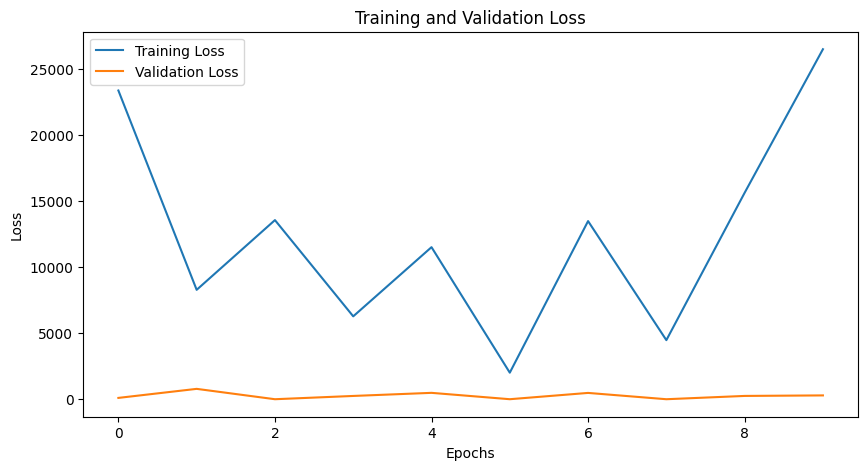

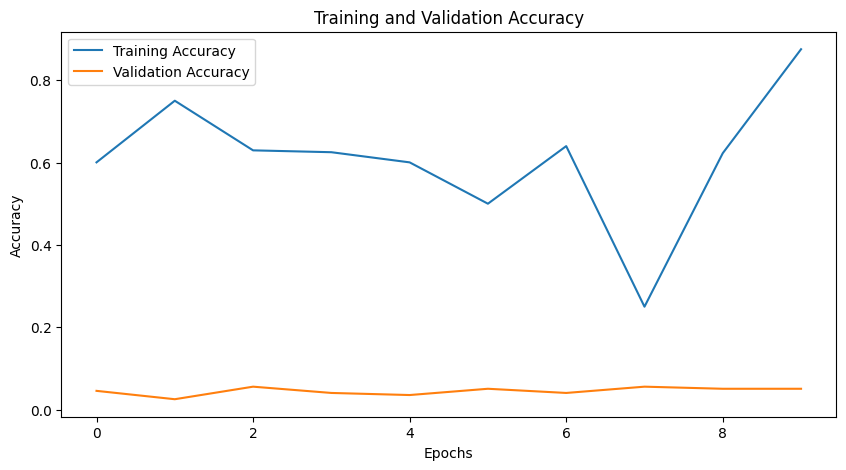

In [142]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Fit the model and save the history
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val))  # Use the EarlyStopping callback

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
